In [1]:
import gym
import time
from typing import Tuple
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import json
import math
import random
import numpy as np
import scipy as sp
import scipy.stats as st
import scipy.integrate as integrate
from scipy.stats import multivariate_normal
from sklearn import linear_model
#from sklearn.utils.testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning
import statsmodels.api as sm
from matplotlib.colors import LogNorm
import pickle
import copy
from joblib import Parallel, delayed
import multiprocessing
from collections import namedtuple
from itertools import count
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
from collections import namedtuple
import cProfile
from datetime import datetime
import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
from torch.autograd import Variable
from typing import Tuple
import random
import logging
import io

sns.set_style("whitegrid")
sns.set_palette("colorblind")
palette = sns.color_palette()
figsize = (15,8)
legend_fontsize = 16

In [2]:
N_ROWS, N_COLS, N_WIN = 3, 3, 3

In [3]:
class TicTacToe(gym.Env):
    def __init__(self, n_rows=N_ROWS, n_cols=N_COLS, n_win=N_WIN, clone=None):
        if clone is not None:
            self.n_rows, self.n_cols, self.n_win = clone.n_rows, clone.n_cols, clone.n_win
            self.board = copy.deepcopy(clone.board)
            self.curTurn = clone.curTurn
            self.emptySpaces = None
            self.boardHash = None
        else:
            self.n_rows = n_rows
            self.n_cols = n_cols
            self.n_win = n_win

            self.reset()

    def getEmptySpaces(self):
        if self.emptySpaces is None:
            res = np.where(self.board == 0)
            self.emptySpaces = np.array([ (i, j) for i,j in zip(res[0], res[1]) ])
        return self.emptySpaces

    def makeMove(self, player, i, j):
        self.board[i, j] = player
        self.emptySpaces = None
        self.boardHash = None

    def getHash(self):
        if self.boardHash is None:
            self.boardHash = ''.join(['%s' % (x+1) for x in self.board.reshape(self.n_rows * self.n_cols)])
        return self.boardHash

    def isTerminal(self):
        # проверим, не закончилась ли игра
        cur_marks, cur_p = np.where(self.board == self.curTurn), self.curTurn
        for i,j in zip(cur_marks[0], cur_marks[1]):
            win = False
            if i <= self.n_rows - self.n_win:
                if np.all(self.board[i:i+self.n_win, j] == cur_p):
                    win = True
            if not win:
                if j <= self.n_cols - self.n_win:
                    if np.all(self.board[i,j:j+self.n_win] == cur_p):
                        win = True
            if not win:
                if i <= self.n_rows - self.n_win and j <= self.n_cols - self.n_win:
                    if np.all(np.array([ self.board[i+k,j+k] == cur_p for k in range(self.n_win) ])):
                        win = True
            if not win:
                if i <= self.n_rows - self.n_win and j >= self.n_win-1:
                    if np.all(np.array([ self.board[i+k,j-k] == cur_p for k in range(self.n_win) ])):
                        win = True
            if win:
                self.gameOver = True
                return self.curTurn

        if len(self.getEmptySpaces()) == 0:
            self.gameOver = True
            return 0

        self.gameOver = False
        return None

    def printBoard(self):
        for i in range(0, self.n_rows):
            print('----'*(self.n_cols)+'-')
            out = '| '
            for j in range(0, self.n_cols):
                if self.board[i, j] == 1:
                    token = 'x'
                if self.board[i, j] == -1:
                    token = 'o'
                if self.board[i, j] == 0:
                    token = ' '
                out += token + ' | '
            print(out)
        print('----'*(self.n_cols)+'-')

    def getState(self):
        return (self.getHash(), self.getEmptySpaces(), self.curTurn)

    def action_from_int(self, action_int):
        return ( int(action_int / self.n_cols), int(action_int % self.n_cols))

    def int_from_action(self, action):
        return action[0] * self.n_cols + action[1]
    
    def step(self, action):
        if self.board[action[0], action[1]] != 0:
            return self.getState(), -10, True, {}
        self.makeMove(self.curTurn, action[0], action[1])
        reward = self.isTerminal()
        self.curTurn = -self.curTurn
        return self.getState(), 0 if reward is None else reward, reward is not None, {}

    def reset(self):
        self.board = np.zeros((self.n_rows, self.n_cols), dtype=int)
        self.boardHash = None
        self.gameOver = False
        self.emptySpaces = None
        self.curTurn = 1

## Часть первая: крестики-нолики при помощи Q-обучения
В коде, прилагающемся к последней лекции про обучение с подкреплением, реализован Environment для крестиков-ноликов, в котором можно при инициализации указывать разные размеры доски и условия победы, а также функции для рисования, в том числе с указанием оценки различных действий. С этим окружением все задания и связаны.
Реализуйте обычное (табличное) Q-обучение. Обучите стратегии крестиков и ноликов для доски 3х3.


In [5]:
env = TicTacToe(n_rows=3, n_cols=3, n_win=3)

In [4]:
import random
import pickle

class Random:
    def random(self, possible_moves):
        return random.choice(possible_moves) ##action

class Qlearning:
    def __init__(self,epsilon=0.2, alpha=0.009, gamma=0.9):
        self.epsilon=epsilon
        self.alpha=alpha
        self.gamma=gamma
        self.Q = {} #Q table
        self.last_board=None
        self.q_last=0.0
        self.state_action_last=None

    def game_begin(self):
        self.last_board = None
        self.q_last = 0.0
        self.state_action_last = None


    def epslion_greedy(self, state, possible_moves): #esplion greedy algorithm
        self.last_board = tuple(state)
        if(random.random() < self.epsilon):
            move = random.choice(possible_moves) ##action
            self.state_action_last=(self.last_board,str(move))
            self.q_last=self.getQ(self.last_board,str(move))
            return move
        else: #greedy strategy
            Q_list=[]
            for action in possible_moves:
                Q_list.append(self.getQ(self.last_board,str(action)))
            maxQ=max(Q_list)

            if Q_list.count(maxQ) > 1:
                best_options = [i for i in range(len(possible_moves)) if Q_list[i] == maxQ]
                i = random.choice(best_options)
            else:
                i = Q_list.index(maxQ)
            self.state_action_last = (self.last_board, str(possible_moves[i]))
            self.q_last = self.getQ(self.last_board, str(possible_moves[i]))
            return possible_moves[i]

    def return_action(self, state, possible_moves): #esplion greedy algorithm
        self.last_board = tuple(state)
        Q_list=[]
        for action in possible_moves:
            Q_list.append(self.getQ(self.last_board,str(action)))
        maxQ=max(Q_list)

        if Q_list.count(maxQ) > 1:
            best_options = [i for i in range(len(possible_moves)) if Q_list[i] == maxQ]
            i = random.choice(best_options)
        else:
            i = Q_list.index(maxQ)
        self.state_action_last = (self.last_board, str(possible_moves[i]))
        self.q_last = self.getQ(self.last_board, str(possible_moves[i]))
        return possible_moves[i]


    def getQ(self, state, action): #get Q states
        if(self.Q.get((state,str(action)))) is None:
            self.Q[(state,str(action))] = 1.0
        return self.Q.get((state,str(action)))

    def updateQ(self, reward, state, possible_moves): # update Q states using Qleanning
        q_list=[]
        for moves in possible_moves:
            q_list.append(self.getQ(tuple(state), str(moves)))
        if q_list:
            max_q_next = max(q_list)
        else:
            max_q_next=0.0
        self.Q[self.state_action_last] = self.q_last + self.alpha * ((reward + self.gamma*max_q_next) - self.q_last)

Обучим крестики и нолики играть друг против друга

In [5]:
def train(env, player1, player2):
    wins_player_1 = 0
    wins_player_2 = 0
    player1.game_begin()
    player2.game_begin()
    env.reset()
    actions = {}
    board_hash, possible_moves, cur_turn = env.getState()
    for moves, v in enumerate(possible_moves):
        actions[str(v)] = moves
    done = False
    while not done:
        if cur_turn == 1:
            move = player1.epslion_greedy(board_hash, possible_moves)
        else:
            move = player2.epslion_greedy(board_hash, possible_moves)
        observation, reward, done, info = env.step(move)
        board_hash = observation[0]
        possible_moves = observation[1]
        board_hash, possible_moves, cur_turn = env.getState()
    player1.updateQ(reward, board_hash, possible_moves)
    player2.updateQ(-1 * reward, board_hash, possible_moves)
    return wins_player_1, wins_player_2, reward

def validate_o(env, player1, player2):
    total_award = []
    for i in range(100):
        wins_player_1 = 0
        wins_player_2 = 0
        player2.game_begin()
        env.reset()
        actions = {}
        board_hash, possible_moves, cur_turn = env.getState()
        for moves, v in enumerate(possible_moves):
            actions[str(v)] = moves
        done = False
        while not done:
            if cur_turn == 1:
                move = player1.random(possible_moves)
            else:
                move = player2.return_action(board_hash, possible_moves)
            observation, reward, done, info = env.step(move)
            board_hash = observation[0]
            possible_moves = observation[1]
            board_hash, possible_moves, cur_turn = env.getState()
        total_award.append(reward)
    return np.mean(total_award)

def validate_x(env, player1, player2):
    total_award = []
    for i in range(100):
        wins_player_1 = 0
        wins_player_2 = 0
        player1.game_begin()
        env.reset()
        actions = {}
        board_hash, possible_moves, cur_turn = env.getState()
        for moves, v in enumerate(possible_moves):
            actions[str(v)] = moves
        done = False
        while not done:
            if cur_turn == 1:
                move = player1.return_action(board_hash, possible_moves)
                
            else:
                move = player2.random(possible_moves)
            observation, reward, done, info = env.step(move)
            board_hash = observation[0]
            possible_moves = observation[1]
            board_hash, possible_moves, cur_turn = env.getState()
        total_award.append(reward)
    return np.mean(total_award)

In [43]:
player1 = Qlearning() #X
player2 = Qlearning() #O
player3 = Random()
wins_x = []
wins_mean_x = []
wins_o = []
wins_mean_o = []
rewards = []
for i in tqdm.tqdm(range(100000)):
    wins_x_list = []
    wins_o_list = []
    reward = train(env, player1, player2)
    if i % 200 == 0:
        reward_x = validate_x(env, player1, player3)
        reward_o = -validate_o(env, player3, player2) 
    #wins_2_list.append(wins_player_2)
        wins_mean_x.append(reward_x)
        wins_mean_o.append(reward_o)
    #print(wins_player_1, wins_player_2, reward)

100%|██████████| 100000/100000 [08:51<00:00, 188.23it/s]


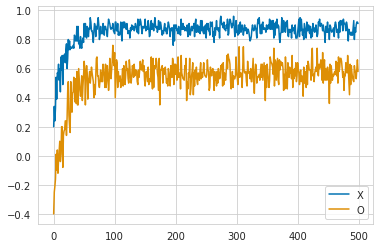

In [44]:
plt.plot(wins_mean_x, label="X")
plt.plot(wins_mean_o, label="O")
plt.legend()

## Выводы: 
epsilon=0.2, alpha=0.009, gamma=0.9
Крестики обучились лучше, нолики обучились не так хорошо. 
Где-то на 20000 итерациях обучение сошлось.

Попробуйте обучить стратегии крестиков и ноликов для доски 4х4 и/или 5х5.

In [7]:
env = TicTacToe(n_rows=4, n_cols=4, n_win=4)

In [11]:
player1 = Qlearning(epsilon=0.3, gamma=1.0) #X
player2 = Qlearning(epsilon=0.3, gamma=1.0) #O
player3 = Random()
wins_x_4 = []
wins_mean_x_4 = []
wins_o_4 = []
wins_mean_o_4 = []
for i in tqdm.tqdm(range(100000)):
    wins_x_list_4 = []
    wins_o_list_4 = []
    reward = train(env, player1, player2)
    if i % 200 == 0:
        reward_x_4 = validate_x(env, player1, player3)
        reward_o_4 = -validate_o(env, player3, player2) 
        wins_mean_x_4.append(reward_x_4)
        wins_mean_o_4.append(reward_o_4)

100%|██████████| 100000/100000 [21:28<00:00, 77.64it/s] 


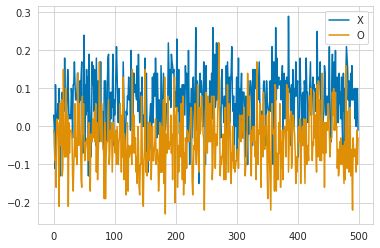

In [12]:
plt.plot(wins_mean_x_4, label="X")
plt.plot(wins_mean_o_4, label="O")
plt.legend()

## Выводы:
epsilon=0.3, alpha=0.009, gamma=1.0
пробовала еще epsilon=0.2, alpha=0.009, gamma=0.9
Видимо пока обучиться не получилось

## Часть вторая: добавим нейронных сетей
Реализуйте нейронную сеть для метода DQN на доске для крестиков-ноликов. Не буду ограничивать фантазию, но кажется, что свёртки 3х3 здесь должны неплохо работать (в том числе обобщаться на доски размера побольше).
Реализуйте DQN с нейронной сетью, обучите стратегии крестиков и ноликов. Замечание: скорее всего, experience replay потребуется сразу же.
Реализуйте Double DQN и/или Dueling DQN.

In [11]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device('cpu')

In [13]:
class ReplayMemory():
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def store(self, exptuple):
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = exptuple
        self.position = (self.position + 1) % self.capacity
       
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    
    def __len__(self):
        return len(self.memory)

In [14]:
class Network_3(nn.Module):
    def __init__(self, conv_out=128): #3*3
        nn.Module.__init__(self)
        self.conv1 = nn.Conv2d(3, conv_out * 2, (3, 3))
        self.lin1 = nn.Linear(conv_out * 2, conv_out)
        self.lin2 = nn.Linear(conv_out, 9)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = torch.flatten(x, 1)
        x = F.relu(self.lin1(x))
        x = self.lin2(x)
        return x



In [17]:
def s_to_tensor(state):
    state = np.array([int(c) for c in state])
    size = int(np.sqrt(len(state)))
    x_array = np.where(state==2, 1, 0).reshape(size, size)
    o_array = np.where(state==0, 1, 0).reshape(size, size)
    empty_spaces = np.where(state==1, 1, 0).reshape(size, size)
    return torch.Tensor(np.stack([x_array, y_array, empty_spaces])).reshape(3, size, size)

In [15]:
class DQN():
    def __init__(self, n_rows, n_cols, n_win, model_class, gamma=0.8, device=device):
        self.env = TicTacToe(n_rows, n_cols, n_win)
        self.n_rows = n_rows
        self.n_cols = n_cols
        self.batch_size = 512
        self.gamma = gamma
        self.eps_init, self.eps_final, self.eps_decay = 0.9, 0.05, 100000
        self.num_step = 0
        self.models = {-1: model_class().to(device), 1: model_class().to(device)}
        self.memories = {-1: ReplayMemory(1000000), 1: ReplayMemory(1000000)}
        self.optimizers = {-1: optim.Adam(self.models[-1].parameters(), lr=0.0001, weight_decay=0.001),
                            1: optim.Adam(self.models[1].parameters(), lr=0.0001, weight_decay=0.001)}
        self.previous_states = {-1: None, 1: None}
        self.previous_actions = {}
        self.steps_done = 0
        self.device = device

    def select_greedy_action(self, state, cur_turn):
        return self.models[cur_turn](state.unsqueeze(0)).data.max(1)[1].view(1, 1)

    def select_action(self, state, cur_turn):
        sample = random.random()
        self.num_step += 1
        eps_threshold = self.eps_final + (self.eps_init - self.eps_final) * math.exp(-1. * self.num_step / self.eps_decay)
        if sample > eps_threshold:
            return self.select_greedy_action(state, cur_turn)
        else:
            return torch.tensor([[random.randrange(self.n_rows * self.n_cols)]], dtype=torch.int64)
        
    def run_episode(self, e=0, do_learning=True, greedy=False):
        self.env.reset()
        self.previous_states = {-1: None, 1: None}
        self.previous_actions = {}
        state, _, cur_turn = self.env.getState()
        while True:
            state_tensor = s_to_tensor(state)
            with torch.no_grad():
                if greedy:
                    action_idx = self.select_greedy_action(state_tensor.to(self.device), cur_turn).cpu()
                else:
                    action_idx = self.select_action(state_tensor.to(self.device), cur_turn).cpu()
            # Сохраняем позицию и совершаемое действие
            self.previous_states[cur_turn] = state_tensor
            self.previous_actions[cur_turn] = action_idx
            action = self.env.action_from_int(action_idx.numpy()[0][0])
            (next_state, empty_spaces, cur_turn), reward, done, _ = self.env.step(action)
            next_state_tensor = s_to_tensor(next_state)
            if reward == -10:
                transition = (state_tensor, action_idx, next_state_tensor, torch.tensor([reward], dtype=torch.float32))
                self.memories[cur_turn].store(transition)
            else:
                if self.previous_states[cur_turn] is not None:
                    if reward == -cur_turn: # Последний ходивший игрок выиграл, текущий cur_turn проиграл - дополним память победителя
                        transition = (self.previous_states[-cur_turn], 
                                      self.previous_actions[-cur_turn], 
                                      next_state_tensor, 
                                      torch.tensor([1.0], dtype=torch.float32)
                                     )
                        self.memories[-cur_turn].store(transition)
                    transition = (self.previous_states[cur_turn], 
                                  self.previous_actions[cur_turn], 
                                  next_state_tensor, 
                                  torch.tensor([reward * cur_turn], dtype=torch.float32)
                                 )
                    self.memories[cur_turn].store(transition)

            
            if do_learning:
                self.learn(cur_turn)

            state = next_state

            if done:
                break

    def learn(self, cur_turn):
        if np.min([len(self.memories[cur_turn]), len(self.memories[-cur_turn])]) < self.batch_size:
            return
        
        # берём мини-батч из памяти
        transitions = self.memories[cur_turn].sample(self.batch_size)
        batch_state, batch_action, batch_next_state, batch_reward = zip(*transitions)

        batch_state = Variable(torch.stack(batch_state).to(self.device))
        batch_action = Variable(torch.cat(batch_action).to(self.device))
        batch_reward = Variable(torch.cat(batch_reward).to(self.device))
        batch_next_state = Variable(torch.stack(batch_next_state).to(self.device))
        
        # считаем значения функции Q
        Q = self.models[cur_turn](batch_state)
        Q = Q.gather(1, batch_action).reshape([self.batch_size])
        
        # оцениваем ожидаемые значения после этого действия
        Qmax = self.models[cur_turn](batch_next_state).detach()
        Qmax = Qmax.max(1)[0]
        Qnext = batch_reward + (self.gamma * Qmax)
        # и хотим, чтобы Q было похоже на Qnext -- это и есть суть Q-обучения
        loss = F.smooth_l1_loss(Q, Qnext)
        self.optimizers[cur_turn].zero_grad()
        loss.backward()
        
        self.optimizers[cur_turn].step()
        
    def test_strategy(self, player, n_episodes=1000):
        rewards = []
        for _ in range(n_episodes):
            self.env.reset()
            state, empty_spaces, cur_turn = self.env.getState()
            done = False
            while not done:
                if cur_turn == player:
                    idx = self.select_greedy_action(s_to_tensor(state).to(device), player)
                    action = self.env.action_from_int(idx)
                else:
                    idx = np.random.randint(len(empty_spaces))
                    action = empty_spaces[idx]
                (state, empty_spaces, cur_turn), reward, done, _ = self.env.step(action)
            if reward != -10:
                rewards.append(reward * player)
            else:
                if cur_turn == player:
                    rewards.append(reward)
        return np.array(rewards)

In [20]:
player = DQN(3, 3, 3, Network_3)
test_episodes = 500
wins_x_3_dqn = []
wins_o_3_dqn = []
for i in tqdm.tqdm(range(20000)):
    player.run_episode(do_learning=True)
    if i % 200 == 0:
        reward_x_dqn = player.test_strategy(1, test_episodes)
        reward_o_dqn = player.test_strategy(-1, test_episodes)
        wins_x_3_dqn.append(np.sum(reward_x_dqn==1)/test_episodes)
        wins_o_3_dqn.append(np.sum(reward_o_dqn==1)/test_episodes)

100%|██████████| 20000/20000 [12:45<00:00, 26.11it/s] 


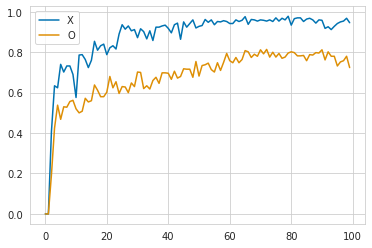

In [21]:
plt.plot(wins_x_3_dqn, label="X")
plt.plot(wins_o_3_dqn, label="O")
plt.legend()

gamma=0.8
Будем считать, что обучение сошлось на 16000 итерациях

Доска 4*4

In [22]:
class Network_4(nn.Module):
    def __init__(self, conv_out=256): #4*4
        nn.Module.__init__(self)
        self.conv1 = nn.Conv2d(3, 16, (3, 3))
        self.conv2 = nn.Conv2d(16, conv_out, (2, 2))
        self.lin1 = nn.Linear(conv_out, 128)
        self.lin2 = nn.Linear(128, 16)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = torch.flatten(x, 1)
        x = F.relu(self.lin1(x))
        x = self.lin2(x)
        return x

In [23]:
player = DQN(4, 4, 4, Network_4)
test_episodes = 500
wins_x_4_dqn = []
wins_o_4_dqn = []
for i in tqdm.tqdm(range(50000)):
    player.run_episode(do_learning=True)
    if i % 200 == 0:
        reward_x_dqn = player.test_strategy(1, test_episodes)
        reward_o_dqn = player.test_strategy(-1, test_episodes)
        wins_x_4_dqn.append(np.sum(reward_x_dqn==1)/test_episodes)
        wins_o_4_dqn.append(np.sum(reward_o_dqn==1)/test_episodes)

100%|██████████| 50000/50000 [1:07:48<00:00, 12.29it/s]  


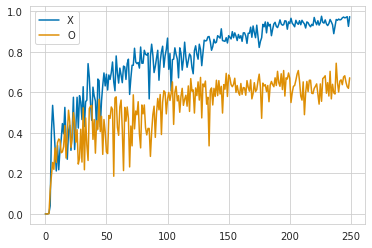

In [25]:
plt.plot(wins_x_4_dqn, label="X")
plt.plot(wins_o_4_dqn, label="O")
plt.legend()

gamma=0.8
Продолжает сходиться даже на 50000 итераций.

Реализуйте Double DQN и/или Dueling DQN.

In [26]:
class Network_3_dueling(nn.Module):
    def __init__(self, conv_out=128): #3*3
        nn.Module.__init__(self)
        self.conv1 = nn.Conv2d(3, conv_out * 2, (3, 3))
        self.lin1 = nn.Linear(conv_out * 2, conv_out)
        self.lin3 = nn.Linear(conv_out, 1)
        self.lin2 = nn.Linear(conv_out, 9)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = torch.flatten(x, 1)
        x = F.relu(self.lin1(x))
        x = self.lin3(x) + (self.lin2(x) - self.lin2(x).mean(dim=1, keepdim=True))
        return x

In [27]:
player = DQN(3, 3, 3, Network_3_dueling)
test_episodes = 500
wins_x_3_dqn_d = []
wins_o_3_dqn_d = []
for i in tqdm.tqdm(range(20000)):
    player.run_episode(do_learning=True)
    if i % 200 == 0:
        reward_x_dqn_d = player.test_strategy(1, test_episodes)
        reward_o_dqn_d = player.test_strategy(-1, test_episodes)
        wins_x_3_dqn_d.append(np.sum(reward_x_dqn_d==1)/test_episodes)
        wins_o_3_dqn_d.append(np.sum(reward_o_dqn_d==1)/test_episodes)

100%|██████████| 20000/20000 [14:54<00:00, 22.35it/s] 


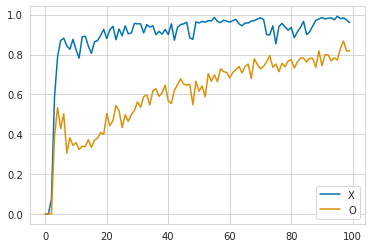

In [28]:
plt.plot(wins_x_3_dqn_d, label="X")
plt.plot(wins_o_3_dqn_d, label="O")
plt.legend()

gamma=0.8
По сравнению с обычным DQN крестики обучились быстрее, нолики обучаются хуже.

In [29]:
class Network_4_dueling(nn.Module):
    def __init__(self, conv_out=256): #4*4
        nn.Module.__init__(self)
        self.conv1 = nn.Conv2d(3, 16, (3, 3))
        self.conv2 = nn.Conv2d(16, conv_out, (2, 2))
        self.lin1 = nn.Linear(conv_out, 128)
        self.lin2 = nn.Linear(128, 1)
        self.lin3 = nn.Linear(128, 16)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = torch.flatten(x, 1)
        x = F.relu(self.lin1(x))
        x = self.lin3(x) + (self.lin2(x) - self.lin2(x).mean(dim=1, keepdim=True))
        return x

In [31]:
player = DQN(4, 4, 4, Network_4_dueling)
test_episodes = 500
wins_x_4_dqn_d = []
wins_o_4_dqn_d = []
for i in tqdm.tqdm(range(50000)):
    player.run_episode(do_learning=True)
    if i % 200 == 0:
        reward_x_dqn_d = player.test_strategy(1, test_episodes)
        reward_o_dqn_d = player.test_strategy(-1, test_episodes)
        wins_x_4_dqn_d.append(np.sum(reward_x_dqn_d==1)/test_episodes)
        wins_o_4_dqn_d.append(np.sum(reward_o_dqn_d==1)/test_episodes)

100%|██████████| 50000/50000 [1:14:29<00:00, 11.19it/s]  


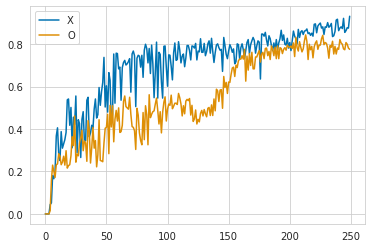

In [33]:
plt.plot(wins_x_4_dqn_d, label="X")
plt.plot(wins_o_4_dqn_d, label="O")
plt.legend()

gamma=0.8
Как и обычный DQN на 50000 итерациях крестики и нолики еще не сошлись окончательно, алгоритм обучается.

## Выводы:
Нейронные сети обе версии ускоряют обучение по сравнению с обычным Q обучением

## Часть третья: 
расширим и углубим поиск Крестики-нолики -- это, конечно, далеко не го, и обычный альфа-бета поиск с отсечением здесь наверняка может работать идеально вплоть до довольно больших досок. Однако мы всё-таки для этого учебного задания будем реализовывать более практически релевантный метод MCTS -- заодно фактически получится и упражнение на многоруких бандитов. Реализуйте rollouts со случайной стратегией и (опционально) rollouts с неслучайной, но простой стратегией (например, основанной на дополнении нескольких паттернов или на Q-функции, которая у вас получилась в первом пункте). Реализуйте MCTS-поиск с этими rollouts для крестиков-ноликов на досках разного размера, сравните полученные стратегии между собой и со стратегиями, обученными в первых двух частях.

In [14]:
def rollout_f_o(env, player1, player2, action, rollouts=100):
    total = []
    for i in range(rollouts):
        env_copy = copy.deepcopy(env)
        env_copy.reset()
        wins_player_1 = 0
        wins_player_2 = 0
        player2.game_begin()
        actions = {}
        observation, reward, done, info = env_copy.step(action)
        board_hash, possible_moves, cur_turn = observation
        for moves, v in enumerate(possible_moves):
            actions[str(v)] = moves
        done = False
        while not done:
            if cur_turn == 1:
                move = player1.random(possible_moves)
            else:
                move = player2.epslion_greedy(board_hash, possible_moves)
            observation, reward, done, info = env_copy.step(move)
            board_hash = observation[0]
            possible_moves = observation[1]
            board_hash, possible_moves, cur_turn = env_copy.getState()
        if (reward == 1):  # won
            wins_player_1 += 1
            player2.updateQ(-1 * reward, board_hash, possible_moves)
        if (reward == -1):
            wins_player_2 += 1
            player2.updateQ(-1 * reward, board_hash, possible_moves)
        if (reward == 0):  # draw
            player2.updateQ(reward, board_hash, possible_moves)
        total.append(reward)
    return np.array(total).mean()

def rollout_f_x(env, player1, player2, action, rollouts=100):
    total = []
    for i in range(rollouts):
        env_copy = copy.deepcopy(env)
        env_copy.reset()
        wins_player_1 = 0
        wins_player_2 = 0
        player1.game_begin()
        actions = {}
        observation, reward, done, info = env_copy.step(action)
        board_hash, possible_moves, cur_turn = observation
        for moves, v in enumerate(possible_moves):
            actions[str(v)] = moves
        done = False
        while not done:
            if cur_turn == -1:
                move = player2.random(possible_moves)
            else:
                move = player1.epslion_greedy(board_hash, possible_moves)
            observation, reward, done, info = env_copy.step(move)
            board_hash = observation[0]
            possible_moves = observation[1]
            board_hash, possible_moves, cur_turn = env_copy.getState()
        if (reward == 1):  # won
            wins_player_1 += 1
            player1.updateQ(reward, board_hash, possible_moves)
        if (reward == -1):
            wins_player_2 += 1
            player1.updateQ(reward, board_hash, possible_moves)
        if (reward == 0):  # draw
            player1.updateQ(reward, board_hash, possible_moves)
        total.append(reward)
    return np.array(total).mean()

In [15]:
def train_with_r_o(env, player1, player2, rollouts=100): #
    total = []
    for i in range(rollouts):
        env_copy = copy.deepcopy(env)
        wins_player_1 = 0
        wins_player_2 = 0
        player2.game_begin()
        actions = {}
        board_hash, possible_moves, cur_turn = env_copy.getState()
        for moves, v in enumerate(possible_moves):
            actions[str(v)] = moves
        done = False
        while not done:
            if cur_turn == 1:
                move = player1.random(possible_moves)
            else:
                best_reward = -10
                for i, cur_move in enumerate(possible_moves):
                    average_reward = rollout_f_o(env, player1, player2, cur_move, rollouts)
                    if average_reward > best_reward:
                        best_reward = average_reward
                        move = cur_move
                    else:
                        move = random.choice(possible_moves)
                #move = player2.epslion_greedy(board_hash, possible_moves)
            observation, reward, done, info = env_copy.step(move)
            #print(reward)
            board_hash = observation[0]
            possible_moves = observation[1]
            board_hash, possible_moves, cur_turn = env_copy.getState()
        if (reward == 1):  # won
            wins_player_1 += 1
            player2.updateQ(-1 * reward, board_hash, possible_moves)
        if (reward == -1):
            wins_player_2 += 1
            player2.updateQ(-1 * reward, board_hash, possible_moves)
        if (reward == 0):  # draw
            player2.updateQ(reward, board_hash, possible_moves)
        total.append(reward)
        #print(np.array(total).mean())
    return np.array(total).mean()

In [16]:
def train_with_r_o(env, player1, player2, rollouts=100): #
    total = []
    for i in range(rollouts):
        env_copy = copy.deepcopy(env)
        wins_player_1 = 0
        wins_player_2 = 0
        player2.game_begin()
        env_copy.reset()
        actions = {}
        board_hash, possible_moves, cur_turn = env_copy.getState()
        for moves, v in enumerate(possible_moves):
            actions[str(v)] = moves
        done = False
        while not done:
            if cur_turn == 1:
                move = player1.random(possible_moves)
            else:
                best_reward = -10
                for i, cur_move in enumerate(possible_moves):
                    average_reward = rollout_f_o(env, player1, player2, cur_move, rollouts)
                    if average_reward > best_reward:
                        best_reward = average_reward
                        move = cur_move
                    else:
                        move = random.choice(possible_moves)
                #move = player2.epslion_greedy(board_hash, possible_moves)
            observation, reward, done, info = env_copy.step(move)
            #print(reward)
            board_hash = observation[0]
            possible_moves = observation[1]
            board_hash, possible_moves, cur_turn = env_copy.getState()
        if (reward == 1):  # won
            wins_player_1 += 1
            player2.updateQ(-1 * reward, board_hash, possible_moves)
        if (reward == -1):
            wins_player_2 += 1
            player2.updateQ(-1 * reward, board_hash, possible_moves)
        if (reward == 0):  # draw
            player2.updateQ(reward, board_hash, possible_moves)
        total.append(reward)
        #print(np.array(total).mean())
    return np.array(total).mean()

def train_with_r_x(env, player1, player2, rollouts=100): #
    total = []
    for i in range(rollouts):
        env_copy = copy.deepcopy(env)
        wins_player_1 = 0
        wins_player_2 = 0
        player1.game_begin()
        env_copy.reset()
        actions = {}
        board_hash, possible_moves, cur_turn = env_copy.getState()
        for moves, v in enumerate(possible_moves):
            actions[str(v)] = moves
        #print(possible_moves)
        done = False
        while not done:
            if cur_turn == 1:
                best_reward = -10
                for i, cur_move in enumerate(possible_moves):
                    average_reward = rollout_f_x(env, player1, player2, cur_move, rollouts)
                    if average_reward > best_reward:
                        best_reward = average_reward
                        move = cur_move
                    else:
                        move = random.choice(possible_moves)
            else:
                move = player2.random(possible_moves)
                #move = player2.epslion_greedy(board_hash, possible_moves)
            observation, reward, done, info = env_copy.step(move)
            #print(reward)
            board_hash = observation[0]
            possible_moves = observation[1]
            board_hash, possible_moves, cur_turn = env_copy.getState()
        if (reward == 1):  # won
            wins_player_1 += 1
            player1.updateQ(reward, board_hash, possible_moves)
        if (reward == -1):
            wins_player_2 += 1
            player1.updateQ(reward, board_hash, possible_moves)
        if (reward == 0):  # draw
            player1.updateQ(reward, board_hash, possible_moves)
        total.append(reward)
        #print(np.array(total).mean())
    return np.array(total).mean()

In [17]:
env = TicTacToe(n_rows=3, n_cols=3, n_win=3)
player1 = Random()
player2 = Qlearning() #X
player3 = Qlearning() #O
wins_o_list = []
wins_x_list = []
for i in tqdm.tqdm(range(200)):
    train_with_r_o(env, player1, player2, 5)
    train_with_r_x(env, player3, player1, 5)
    reward_o = -validate_o(env, player1, player2)
    reward_x = validate_x(env, player3, player1)
    wins_o_list.append(reward_o)
    wins_x_list.append(reward_x)

100%|██████████| 200/200 [07:26<00:00,  2.23s/it]


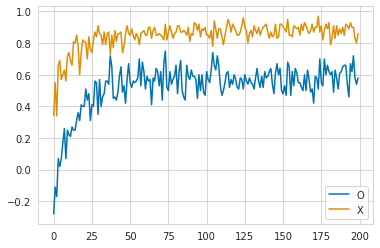

In [20]:
plt.plot(wins_o_list, label="O")
plt.plot(wins_x_list, label="X")
plt.legend()

epsilon=0.2, alpha=0.009, gamma=0.9

In [23]:
env = TicTacToe(n_rows=4, n_cols=4, n_win=4)
player1 = Random()
player2 = Qlearning() #X
player3 = Qlearning() #O
wins_o_list_4 = []
wins_x_list_4 = []
for i in tqdm.tqdm(range(100)):
    train_with_r_o(env, player1, player2, 7)
    train_with_r_x(env, player3, player1, 7)
    reward_o = -validate_o(env, player1, player2)
    reward_x = validate_x(env, player3, player1)
    wins_o_list_4.append(reward_o)
    wins_x_list_4.append(reward_x)

100%|██████████| 100/100 [50:58<00:00, 30.58s/it]


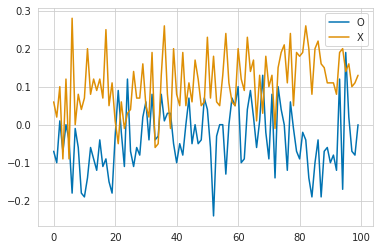

In [24]:
plt.plot(wins_o_list_4, label="O")
plt.plot(wins_x_list_4, label="X")
plt.legend()

epsilon=0.2, alpha=0.009, gamma=0.9

## Выводы:
С ролаутами против случайной стратегии модель обучается гораздо быстрее чем табличное Q обучение на доске 3 на 3. На доске 4 на 4 обучиться не получилось. Подозреваю, что низкое количество ролаутов, однако, обучение занимает длительное время, не рискнула увеличивать их количество как и число итераций.

На этом все, MCTS реализовать не успела.

In [ ]:
from abc import ABC, abstractmethod
from collections import defaultdict
import math


class MCTS:
    "Monte Carlo tree searcher. First rollout the tree then choose a move."

    def __init__(self, exploration_weight=1):
        self.Q = defaultdict(int)  # total reward of each node
        self.N = defaultdict(int)  # total visit count for each node
        self.children = dict()  # children of each node
        self.exploration_weight = exploration_weight

    def choose(self, node):
        "Choose the best successor of node. (Choose a move in the game)"
        if node.is_terminal():
            raise RuntimeError(f"choose called on terminal node {node}")

        if node not in self.children:
            return node.find_random_child()

        def score(n):
            if self.N[n] == 0:
                return float("-inf")  # avoid unseen moves
            return self.Q[n] / self.N[n]  # average reward

        return max(self.children[node], key=score)

    def do_rollout(self, node):
        "Make the tree one layer better. (Train for one iteration.)"
        path = self._select(node)
        leaf = path[-1]
        self._expand(leaf)
        reward = self._simulate(leaf)
        self._backpropagate(path, reward)

    def _select(self, node):
        "Find an unexplored descendent of `node`"
        path = []
        while True:
            path.append(node)
            if node not in self.children or not self.children[node]:
                # node is either unexplored or terminal
                return path
            unexplored = self.children[node] - self.children.keys()
            if unexplored:
                n = unexplored.pop()
                path.append(n)
                return path
            node = self._uct_select(node)  # descend a layer deeper

    def _expand(self, node):
        "Update the `children` dict with the children of `node`"
        if node in self.children:
            return  # already expanded
        self.children[node] = node.find_children()

    def _simulate(self, node):
        "Returns the reward for a random simulation (to completion) of `node`"
        invert_reward = True
        while True:
            if node.is_terminal():
                reward = node.reward()
                return 1 - reward if invert_reward else reward
            node = node.find_random_child()
            invert_reward = not invert_reward

    def _backpropagate(self, path, reward):
        "Send the reward back up to the ancestors of the leaf"
        for node in reversed(path):
            self.N[node] += 1
            self.Q[node] += reward
            reward = 1 - reward  # 1 for me is 0 for my enemy, and vice versa

    def _uct_select(self, node):
        "Select a child of node, balancing exploration & exploitation"

        # All children of node should already be expanded:
        assert all(n in self.children for n in self.children[node])

        log_N_vertex = math.log(self.N[node])

        def uct(n):
            "Upper confidence bound for trees"
            return self.Q[n] / self.N[n] + self.exploration_weight * math.sqrt(
                log_N_vertex / self.N[n]
            )

        return max(self.children[node], key=uct)


class Node(ABC):
    """
    A representation of a single board state.
    MCTS works by constructing a tree of these Nodes.
    Could be e.g. a chess or checkers board state.
    """

    @abstractmethod
    def find_children(self):
        "All possible successors of this board state"
        return set()

    @abstractmethod
    def find_random_child(self):
        "Random successor of this board state (for more efficient simulation)"
        return None

    @abstractmethod
    def is_terminal(self):
        "Returns True if the node has no children"
        return True

    @abstractmethod
    def reward(self):
        "Assumes `self` is terminal node. 1=win, 0=loss, .5=tie, etc"
        return 0

    @abstractmethod
    def __hash__(self):
        "Nodes must be hashable"
        return 123456789

    @abstractmethod
    def __eq__(node1, node2):
        "Nodes must be comparable"
        return True